# Lip reading model

## 0. Installing and importing dependencies

In [1]:
!pip install opencv-python matplotlib imageio gdown tensorflow

- **opencv-python** is used for image processing
- **matplotlib** is used for visualization
- **imageio** is used for reading video files to gifs
- **gdowm** is used for downloading files
- **tensorflow** is used for deep learning

In [65]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable


In [1]:
!pip list

Package                       Version
----------------------------- ---------------
absl-py                       1.4.0
aiobotocore                   2.4.2
aiofiles                      22.1.0
aiohttp                       3.8.3
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-catalogs             0.2.0
anaconda-client               1.12.0
anaconda-navigator            2.4.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         22.1.0
Automat                       20.2.0
autopep8

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf

from typing import List
from matplotlib import pyplot as plt
import imageio

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
# Prevent exponential GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
try :
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except :
    print('Invalid device or cannot modify virtual devices once initialized.')
    pass

Invalid device or cannot modify virtual devices once initialized.


## 1. Build Data Loading Function

In [53]:
# Downloadin dataset
import gdown
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=7e304dfa-5dca-4e6e-9856-951d24722035
To: C:\Users\aitay\Documents\Github\Lipreading\data.zip
  0%|          | 0.00/423M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [5]:
# Load videos
def load_video(path:str) -> List[float]:
    """
    Loads a video from a given path, reduces the size of the video and standardizes it.
    :param path: Path to the video
    :return: A list of standardized frames
    """

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame) # Less data to process
        frames.append(frame[190:236,80:220,:]) # This is the region of interest (ROI) that contains the mouth
        # However we can replace it with a face detector library like dlib
    cap.release()

    # We standardize the frames so that they have a mean of 0 and standard deviation of 1.
    # (Scaling data, good practice)
    mean = tf.math.reduce_mean(frames)
    casted_frames= tf.cast(frames, tf.float32)
    std = tf.math.reduce_std(casted_frames)
    return tf.cast((frames - mean), tf.float32) / std

In [6]:
# Defining vocabulary
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'1234567890? "]

In [7]:
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '0',
 '?',
 ' ']

In [8]:
# A nice and neat way to convert charts to nums and vice versa
# This is taking from Keras Automatic speech recognition using CTC
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    oov_token="",
    invert=True
)
print(
    f"Input: {vocab}\n",
    f"Output: {char_to_num.vocabulary_size()}\n"
)

Input: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '?', ' ']
 Output: 40



In [9]:
# Testing
char_to_num(['a','y','y'])
# So what we are doing is that we are converting the characters to numbers
# This will help us later on converting these values to one-hot-coded

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([ 1, 25, 25], dtype=int64)>

In [10]:
num_to_char([ 1, 25, 25])

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'a', b'y', b'y'], dtype=object)>

In [11]:
# Load alignments
# Alignments are the text that is being said in the video
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        alignments = f.readlines()
    tokens = []
    for alignment in alignments:
        alignment = alignment.split()
        if alignment[2] != 'sil':
            tokens = [*tokens, ' ', alignment[2]]
    tokens_unicode= tf.strings.unicode_split(tokens, 'UTF-8')
    # print(tokens_unicode)
    # Reshape the tensor to remove the first empty space
    # tokens_unicode = tf.reshape(tokens_unicode, [1, -1])
    # print(char_to_num(tokens_unicode)[1:])
    return char_to_num(tf.reshape(tokens_unicode, [-1]))[1:]

In [12]:
# Load data from the dataset
def load_data(path:str):
    """
    This function will load the data from the folder and call the load_video and load_alignments functions to import the frames and alignments simultaneously
    :param path: Path to the dataset
    :return: frames, alignments
    """
    path = bytes.decode(path.numpy()) # Convert the path to a string
    file_name = path.split('\\')[-1].split('.')[0] # Get the file name
    video_path = os.path.join('data','sequences',f'{file_name}.mpg') # Get the video path
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align') # Get the alignment path
    return load_video(video_path), load_alignments(alignment_path)

In [13]:
# Just to quickly transform the alignments to text
def alignments_to_text(alignments:List[int]) -> str:
    return tf.strings.reduce_join(num_to_char(alignments)).numpy().decode('utf-8')

In [14]:
# Testing
test_path = '.\\data\\sequences\\bbal6n.mpg'
tensor_path= tf.convert_to_tensor(test_path)
frames, alignments=load_data(tensor_path)

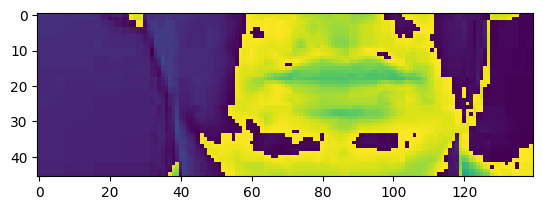

In [15]:
plt.imshow(frames[0])

In [16]:
alignments_to_text(alignments)

'bin blue at l six now'

In [17]:
def mappabale_function (path:str)->List[str]:
    """
    This function is used to map the load_data function to the dataset
    :param path: Path to the dataset
    :return:
    """
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

## 2. Data Pipeline

In [18]:
# Load the dataset
dataset = tf.data.Dataset.list_files(os.path.join('data','sequences','*.mpg'))
dataset =dataset.shuffle(100, reshuffle_each_iteration=False) # Shuffle the dataset
dataset = dataset.map(mappabale_function) # Map the load_data function to the dataset
dataset = dataset.padded_batch(2,padded_shapes=([75,None,None,None],[40])) # Pad the dataset, which means that we will make all the videos have the same length
dataset = dataset.prefetch(tf.data.AUTOTUNE) # Prefetch the dataset whilw thw model is training

In [19]:
# Splitting training set and test set
train_dataset = dataset.take(50)
test_dataset = dataset.skip(50)

In [20]:
# Testing
frames, alignments = dataset.as_numpy_iterator().next()

In [21]:
len(frames)

2

In [22]:
test = dataset.as_numpy_iterator()
val=test.next()
val[0]

array([[[[[ 1.4727489 ],
          [ 1.4727489 ],
          [ 1.5115054 ],
          ...,
          [ 0.03875655],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.4727489 ],
          [ 1.4727489 ],
          [ 1.5115054 ],
          ...,
          [ 0.03875655],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.3564792 ],
          [ 1.3564792 ],
          [ 1.3564792 ],
          ...,
          [ 0.03875655],
          [ 0.03875655],
          [ 0.03875655]],

         ...,

         [[ 1.0076703 ],
          [ 1.0076703 ],
          [ 1.0076703 ],
          ...,
          [ 9.65038   ],
          [ 9.65038   ],
          [ 9.65038   ]],

         [[ 0.9301571 ],
          [ 0.9301571 ],
          [ 0.9301571 ],
          ...,
          [ 9.611624  ],
          [ 9.611624  ],
          [ 9.611624  ]],

         [[ 0.9301571 ],
          [ 0.9301571 ],
          [ 0.9301571 ],
          ...,
          [ 9.611624  ],
          [ 9.611624  ],
          

In [23]:
# Additionally, we can export the gif of the video
imageio.mimsave('test.gif', val[0][1])

Lossy conversion from float32 to uint8. Range [0.0, 10.715871810913086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.715871810913086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.715871810913086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.715871810913086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.715871810913086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.715871810913086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 10.715871810913086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to u

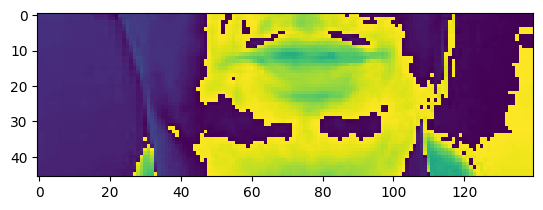

In [24]:
plt.imshow(val[0][0][35])
# 0 : videos, 0 : first video, 1 : second fram

In [25]:
alignments_to_text(val[1][0])

'place red with d seven again'

## 3. Building the deep neural network

In [45]:
pip install tensorflow==2.8

Note: you may need to restart the kernel to use updated packages.


In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [27]:
model = Sequential()
model.add(Conv3D(128, 3, padding='same', input_shape=(75,46,140,1)))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocab_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [29]:
# Testing without training
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [30]:
tf.strings.reduce_join(num_to_char(tf.argmax(yhat[0], axis=1))).numpy().decode('utf-8')

'111111100000000011110000000000000000011111111111111111111111111111111kkpppk'

In [31]:
tf.argmax(yhat[0], axis=1)

<tf.Tensor: shape=(75,), dtype=int64, numpy=
array([28, 28, 28, 28, 28, 28, 28, 37, 37, 37, 37, 37, 37, 37, 37, 37, 28,
       28, 28, 28, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
       37, 37, 37, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 11, 11, 16, 16, 16, 11], dtype=int64)>

## 4. Training the model (setting up the options)

In [32]:
def scheduler(epoch, lr):
    if epoch < 30 :
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [33]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [59]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset
        #self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for i in range(len(yhat)):
            print(f'Predicted: {alignments_to_text(decoded[i])}')
            print(f'Actual: {alignments_to_text(data[1][i])}')
            print('-------------------')

In [60]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-3), loss=CTCLoss)

In [61]:
# Create the callbacks
checkpoint = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='val_loss', save_best_only=True, save_weights_only=True)

In [62]:
schedule_callback = LearningRateScheduler(scheduler)

In [63]:
example_callback = ProduceExample(test) #How well the model is doing

In [40]:
# Train the model
model.fit(train_dataset, validation_data=test_dataset, epochs=50, callbacks=[checkpoint,schedule_callback,example_callback] )

1/1 [==============================] - 5s 5s/step
Predicted:  e   
Actual: place blue at v five again
-------------------
Predicted:  e   
Actual: place blue in b nine again
-------------------
50/50 [==============================] - 3984s 80s/step - loss: 111.6005 - val_loss: 91.7966 - lr: 0.0010
Epoch 2/50
1/1 [==============================] - 3s 3s/step
Predicted:  e e e e 
Actual: lay blue by e zero now
-------------------
Predicted:  e e e e 
Actual: place white by k two please
-------------------
50/50 [==============================] - 3810s 77s/step - loss: 85.4604 - val_loss: 75.8203 - lr: 0.0010
Epoch 3/50
1/1 [==============================] - 3s 3s/step
Predicted: l e e e e n
Actual: bin red in f five soon
-------------------
Predicted: l e e e e n
Actual: place green with r five soon
-------------------
50/50 [==============================] - 3865s 78s/step - loss: 76.4478 - val_loss: 72.3355 - lr: 0.0010
Epoch 4/50
1/1 [==============================] - 3s 3s/step
Pred

Epoch 1/50
1/1 [==============================] - 5s 5s/step
Predicted: la re it ie aon
Actual: set blue by b one again
-------------------
Predicted: la re it ie aon
Actual: place white in p nine again
-------------------
50/50 [==============================] - 4646s 94s/step - loss: 52.0375 - val_loss: 48.0550 - lr: 1.3534e-04
Epoch 2/50
1/1 [==============================] - 5s 5s/step
Predicted: la re it ie aon
Actual: lay green at s two now
-------------------
Predicted: la re it ie aon
Actual: place green at y zero now
-------------------
50/50 [==============================] - 4598s 93s/step - loss: 51.5157 - val_loss: 48.0425 - lr: 1.3534e-04
Epoch 3/50
1/1 [==============================] - 5s 5s/step
Predicted: la re it ie aon
Actual: lay white at r six now
-------------------
Predicted: la re it ie aon
Actual: place white with q nine soon
-------------------
50/50 [==============================] - 4579s 92s/step - loss: 52.1273 - val_loss: 47.6186 - lr: 1.3534e-04
Epoch 4

KeyboardInterrupt: 

In [41]:
# Train the model on 100 epochs
model.fit(train_dataset, validation_data=test_dataset, epochs=100, callbacks=[checkpoint,schedule_callback,example_callback] )

Epoch 1/100
1/1 [==============================] - 3s 3s/step
Predicted: la re it ie aon
Actual: bin blue at l six now
-------------------
Predicted: la re it ie aon
Actual: place white at d three soon
-------------------
50/50 [==============================] - 3945s 80s/step - loss: 52.0007 - val_loss: 48.0193 - lr: 1.3534e-04
Epoch 2/100
1/1 [==============================] - 3s 3s/step
Predicted: la re it ie aon
Actual: bin red with g eight please
-------------------
Predicted: la re it ie aon
Actual: set green at i eight please
-------------------
50/50 [==============================] - 3715s 75s/step - loss: 50.8050 - val_loss: 47.3838 - lr: 1.3534e-04
Epoch 3/100
1/1 [==============================] - 3s 3s/step
Predicted: la re it ie aon
Actual: lay white in r two now
-------------------
Predicted: la re it ie aon
Actual: place blue by p five again
-------------------
50/50 [==============================] - 3719s 75s/step - loss: 50.7246 - val_loss: 47.3040 - lr: 1.3534e-04
E

## 5. Making predictions

In [66]:
import gdown
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=faed68ac-cc33-4787-aa9c-037d832cd8ae
To: C:\Users\aitay\Documents\Github\lipreadingModel\checkpoints.zip
100%|██████████| 94.5M/94.5M [10:50<00:00, 145kB/s] 


['models\\checkpoint.index',
 'models\\__MACOSX/._checkpoint.index',
 'models\\checkpoint.data-00000-of-00001',
 'models\\__MACOSX/._checkpoint.data-00000-of-00001',
 'models\\checkpoint',
 'models\\__MACOSX/._checkpoint']

In [69]:
model.load_weights(os.path.join('models','checkpoint'))

ValueError: You are trying to restore a checkpoint from a legacy Keras optimizer into a v2.11+ Optimizer, which can cause errors. Please update the optimizer referenced in your code to be an instance of `tf.keras.optimizers.legacy.Optimizer`, e.g.: `tf.keras.optimizers.legacy.Adam`.

In [70]:
# Load the dataset
test = test_dataset.as_numpy_iterator()

In [71]:
sample = test.next()

In [73]:
yhat = model.predict(sample[0])

1/1 [==============================] - 9s 9s/step


In [74]:
print('~'*10, 'REAL TEXT', '~'*10)
print(alignments_to_text(sample[1][0]))

~~~~~~~~~~ REAL TEXT ~~~~~~~~~~
place green with l three again


In [75]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [76]:
print('~'*10, 'PREDICTED TEXT', '~'*10)
print(alignments_to_text(decoded[0]))

~~~~~~~~~~ PREDICTED TEXT ~~~~~~~~~~
bla gree it ie oon


## 6. Testing on a video

In [77]:
sample = load_data(tf.convert_to_tensor('.\\data\\sequences\\bras9a.mpg'))

In [89]:
print('~'*10, 'REAL TEXT', '~'*10)
print(alignments_to_text(sample[1]))

~~~~~~~~~~ REAL TEXT ~~~~~~~~~~
bin red at s nine again


In [90]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 2s 2s/step


In [91]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [92]:
print('~'*10, 'PREDICTED TEXT', '~'*10)
print(alignments_to_text(decoded[0]))

~~~~~~~~~~ PREDICTED TEXT ~~~~~~~~~~
bla gree it ie oon
